# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [129]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import mat73
import speckleret as spr

data_path = 'C:/ML/datasets/data_f_60mm_good.mat'
# data_path = 'C:/ML/datasets/data_base_CP_CL_f_60mm_2_cameras_6_6.mat'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the interferometric data

In [130]:
CL = loadmat(data_path)['CL']
CP = loadmat(data_path)['CP']

# CL = mat73.loadmat(data_path)['CL']
# CP = mat73.loadmat(data_path)['INTERFERENCE']

print(len(CL), len(CL[0]), CL[0][0].shape)
print(len(CP), len(CP[0]), CP[0][0].shape)

1 100 (512, 512)
1 100 (801, 801)


### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

10.430112387527624


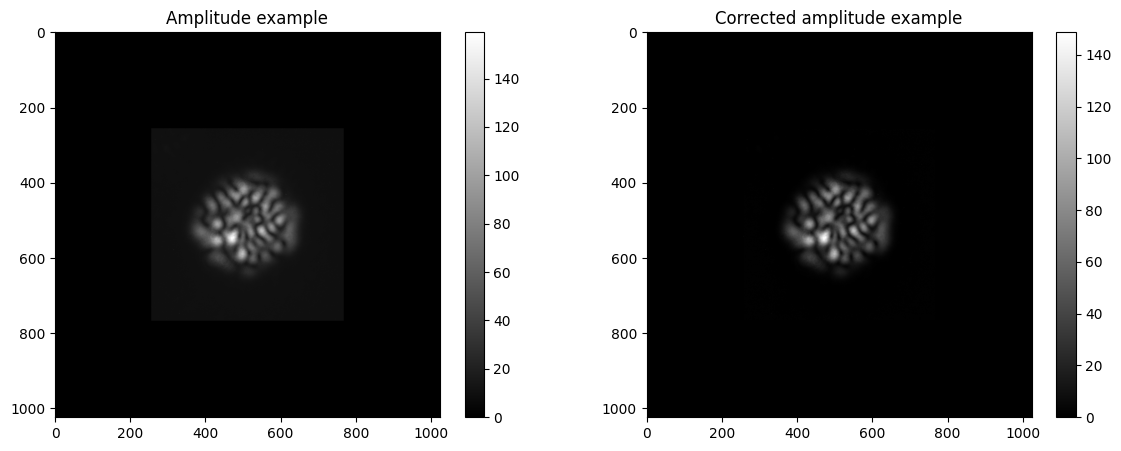

In [131]:
noise_corr = spr.utils.extract_noise_correction(CL, mask_trsh=0.02, plot_result=True)
print(noise_corr)

c:\users\saucourt\coding\speckle-retrieval\speckleret\utils.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  return scipy.ndimage.center_of_mass(array)


0.0033801595891297348


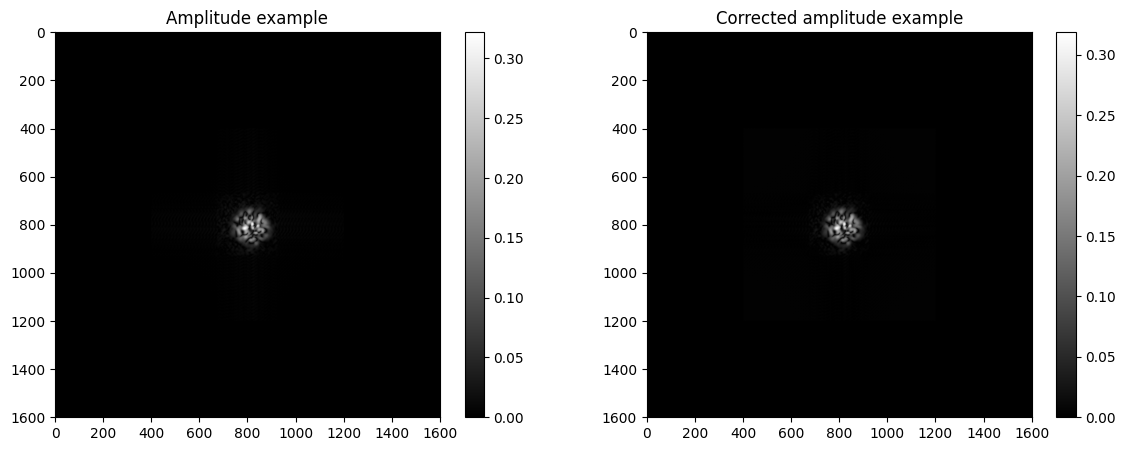

In [132]:
noise_corrCP = spr.utils.extract_noise_correction(CP, mask_trsh=0.02, plot_result=True)
print(noise_corrCP)

Let's detect the average centroids

In [184]:
centroids_CP = spr.utils.extract_average_centroid(CP)
centroids_CL = spr.utils.extract_average_centroid(CL)

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

c:\users\saucourt\coding\speckle-retrieval\speckleret\utils.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  return scipy.ndimage.center_of_mass(array)


Average centroid CP: (403.64276952096066, 409.0861829544768)
Average centroid CL: (252.97837852154788, 253.63111429375599)


### Data preparation

Select data for phase retrieval

In [259]:
idx = 7
random: bool = True
if random:
    idx = np.random.randint(0, len(CP[0]))

(314, 314) 38.244470489012485
(314, 314) 1271989.6


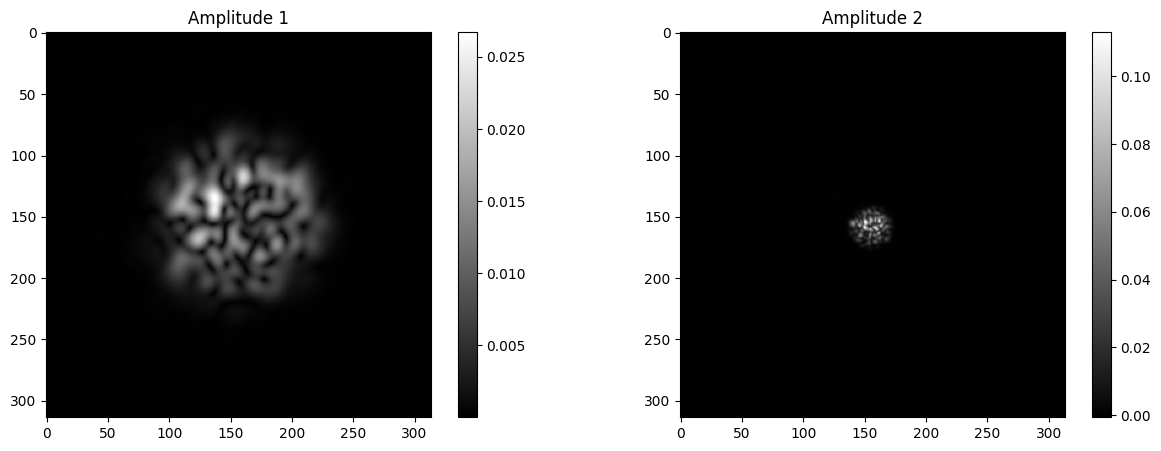

In [260]:
field = CP[0][idx]# - noise_corrCP
start = 253
stop = start + 314

CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = np.roll(field, shift=-CP_shift, axis=(0,1))
# field = spr.transforms.pad_img(field, 0.23)
# field = field[156:-157, 156:-157]
field = field[start:stop, start:stop]
# field = field[:-1, :-1]

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(CL[0][idx]) - noise_corr
# centroids_CL = spr.utils.get_centroid(ft)
CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
# ft = ft[:-1,:-1]
ft = spr.utils.bin_image(ft, factor=8)
# ft = spr.transforms.pad_img(ft, 3.92)
ft = spr.transforms.pad_img(ft, 3.92)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

# _ = spr.plots.compare_arrays(field[1000:1500,1000:1500], ft[1000:1500,1000:1500], cmap='gray')
_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

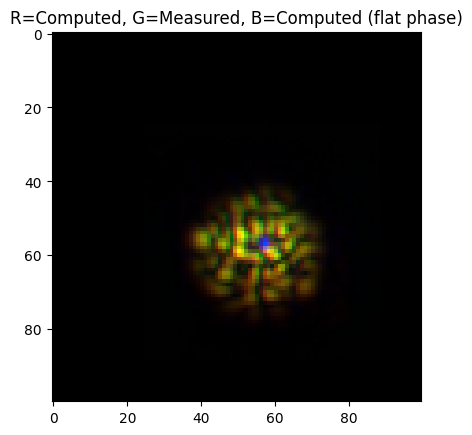

In [261]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)

_ = spr.plots.rgb_imshow([np.abs(ft_field[100:200, 100:200])*0.5, np.abs(ft[100:200, 100:200])*0.5,  np.abs(ft_field_flat[100:200, 100:200])])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

Define the phase retrieval support

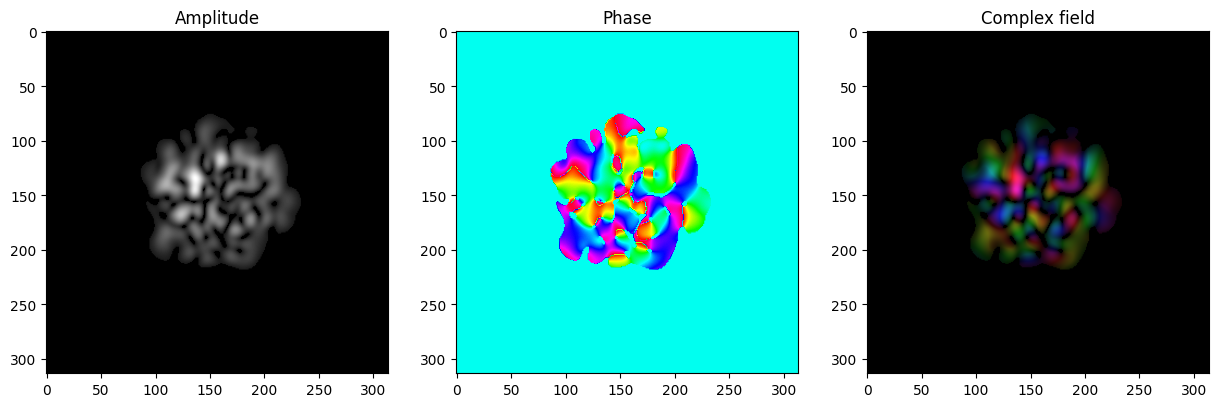

In [262]:
support = spr.supports.threshold_support(field, threshold=0.01)
supported_field = field.copy()
supported_field[np.logical_not(support)] = 0
_ = spr.plots.complex_imshow(supported_field)

### Phase retrieval

Run the phase retrieval. From now, a good setup includes:
- Flat phases initialization
- HIO iterations to refine the phase initialization
- ER iterations to converge to the solution

1 / 1
Quality: 0.7201124346807704
Pearson: 0.9999999999999998


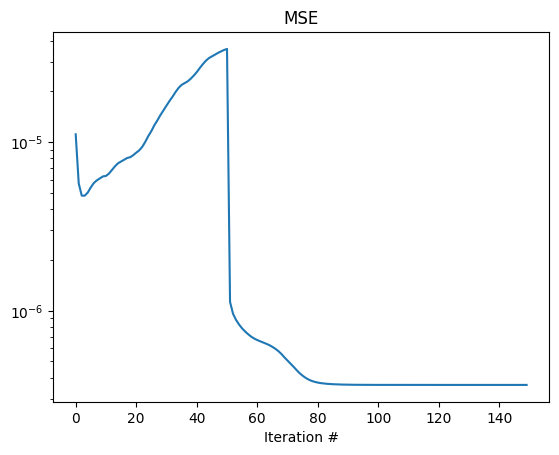

In [263]:
init = spr.initializers.flat_phases(np.abs(field))
y_hat, ft_hat, results = spr.retrieval.hio_er_fourier((np.abs(field), np.abs(ft)), support, pad=None, init=init, beta=0.99, max_iter=1, max_er_iter=100, max_hio_iter=50)

print(f"Quality: {spr.metrics.quality(y_hat[support], field[support])}")
print(f"Pearson: {spr.metrics.pearson(y_hat[support], field[support])}")

plt.figure()
plt.plot(results['mse_plane2'], label='Fourier MSE')
plt.title('MSE')
plt.xlabel('Iteration #')
plt.yscale('log')

Check the results with the target, and display the phase difference with the target (it is likely to contain a phase slope due to Fourier magnitudes misalignments)

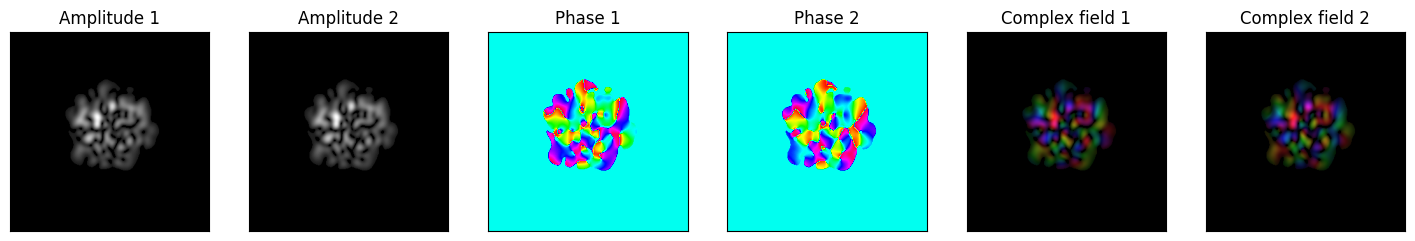

Phase error:
  - Mean: 1.36701 rad
  - Std: 0.71337 rad


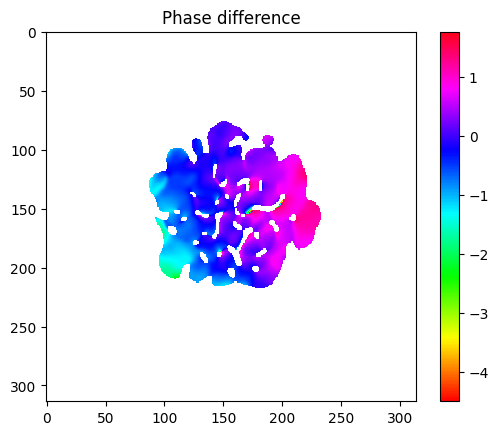

In [264]:
_ = spr.plots.compare_complex_fields(
    spr.transforms.apply_mask(field, support),
    spr.transforms.apply_mask(y_hat, support),
    remove_ticks=True, figsize=(18,6)
    )
plt.show()

spr.plots.phase_difference(y_hat, field, support)
plt.show()

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR works well.

Qualities:	 Last = 0.73808,	 Last_phi = 0.63906


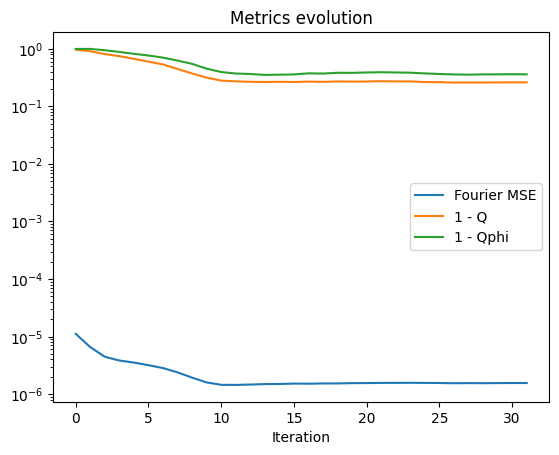

In [265]:
x, results = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        target_field=field,
        algorithm=spr.retrievalmath.RAAR,
        algorithm_kwargs={'beta': 0.7},
        max_iter=100,
        rel_tol=1e-3,
        )

spr.retrievalmath.report_convergence_results(results)

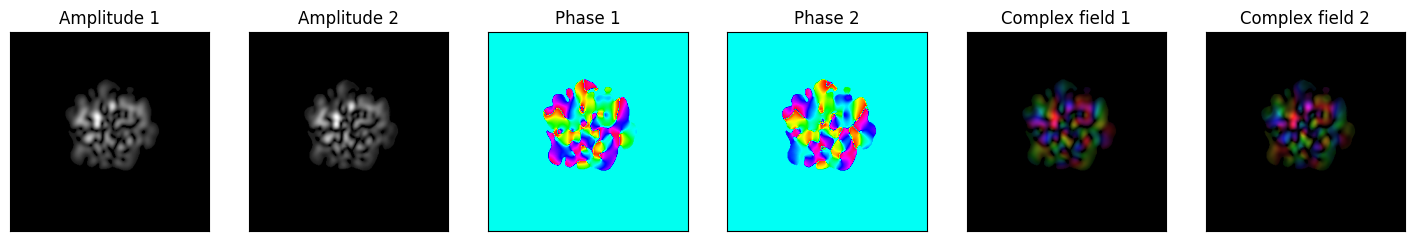

Phase error:
  - Mean: 1.68435 rad
  - Std: 0.71242 rad


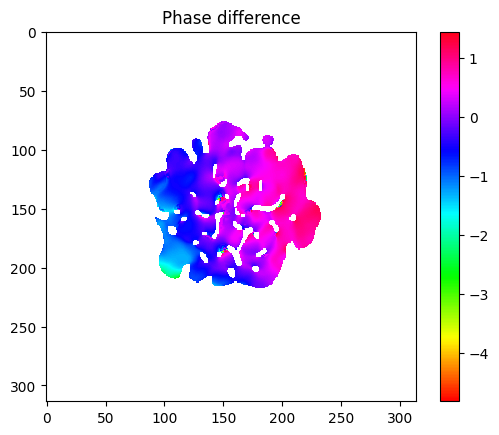

In [266]:
_ = spr.plots.compare_complex_fields(
    spr.transforms.apply_mask(field, support),
    spr.transforms.apply_mask(x, support),
    remove_ticks=True, figsize=(18,6)
    )
plt.show()

diff = spr.plots.phase_difference(x, field, support)
plt.show()

Attempt to remove the slope: might work if it is faint (not wrapped)

In [267]:
from scipy.optimize import curve_fit

def func_lin(x, a, b, c):
    return a * x[0] + b * x[1] + c

x_grid = np.arange(0, x.shape[0])
y_grid = np.arange(0, x.shape[1])
X, Y = np.meshgrid(x_grid, y_grid)
X_supp, Y_supp = X[support], Y[support]

x_fit_data = np.vstack((X_supp.reshape((1, X_supp.size)), Y_supp.reshape((1, Y_supp.size))))
y_fit_data = diff[~np.isnan(diff)]
print(x_fit_data.shape, y_fit_data.shape)


# Curve fit
popt, pcov = curve_fit(func_lin, x_fit_data, y_fit_data)
print("fitted: {}".format(popt))
z_fit = func_lin(x_fit_data, *popt)
# Z_fit = z_fit.reshape(*X.shape)


(2, 13798) (13798,)
fitted: [ 0.01576642 -0.00478779 -0.07335113]


Std: 0.3029991045019296 rad
Lamnbda / X rms: 20.7 rms


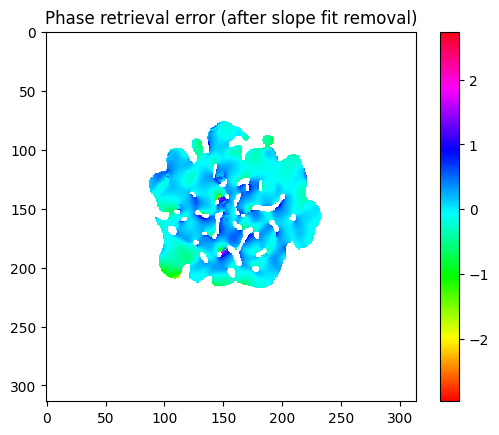

In [270]:
diff_corr = np.zeros_like(diff) * np.nan
diff_corr[support] = np.angle(np.exp(1j * (diff[support] - z_fit)))

print(f"Std: {np.nanstd(diff_corr)} rad")
print(f"Lambda / X rms: {2 * np.pi / np.nanstd(diff_corr):3.1f} rms")

plt.figure()
plt.imshow(diff_corr, cmap='hsv')
plt.title("Phase retrieval error (after slope fit removal)")
plt.colorbar()